# Simulating different noises in Pulser

## 1. Introduction
 $\newcommand{\Ket}[1]{\left|#1\right>}$
This notebook gives an overview of how to simulate several kinds of noise in Pulser. Quantum computers aren't perfect and are susceptible to various sources of noise. In order to simulate these quantum computations in Pulser, we need to take them into account. 

As of now, the types of noise implemented in Pulser are :
* SPAM (State Preparation And Measurement) errors : There are three types of such errors, one (with probability $\eta$) related to bad initial state preparation of the all-ground state $\Ket{g}^{\otimes n}$, and two (with probabilities $\epsilon, \epsilon '$) linked to detection errors. During the simulation, excited Rydberg atoms in $\Ket{r}$ might decay to the state $\Ket{g}$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $\Ket{g}$ might be excited due to various causes (collisions...) and tweezer recapture might fail, inferring them incorrectly as atoms in $\Ket{r}$ : those are the false positives modeled by $\epsilon$.
* Doppler damping : The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population.
* Amplitude noise : For global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.

In [2]:
from pulser import Register, Pulse, Sequence, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

import numpy as np
import matplotlib.pyplot as plt
import qutip

## Single Atom

Prepare a single atom:

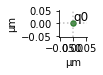

In [3]:
reg = Register.from_coordinates([(0,0)], prefix='q')
reg.draw()

Act on this atom with a Constant Pulse (a $2\pi$-pulse), such that it oscillates towards the excited Rydberg state and back to the original state:

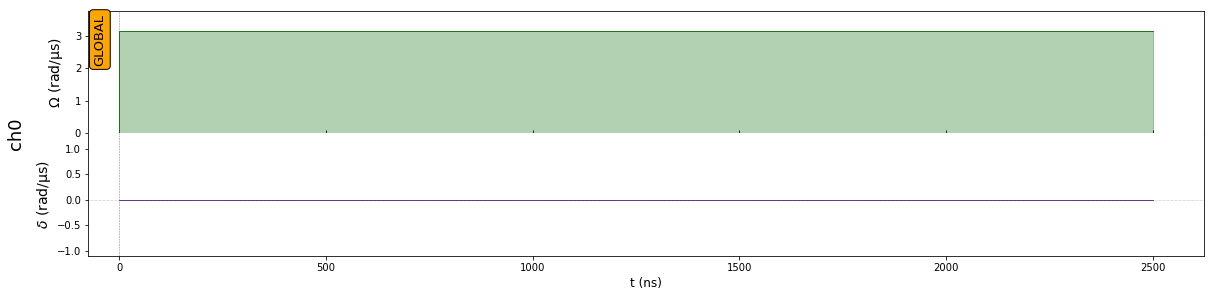

In [4]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0', 'rydberg_global')
duration = 2500
pulse = Pulse.ConstantPulse(duration, np.pi, 0.*2*np.pi, 0)
seq.add(pulse, 'ch0')
seq.draw()

We now run the noiseless simulation, to obtain a `CleanResults` object in `res`.

In [5]:
sim = Simulation(seq, sampling_rate=0.01)
res = sim.run()

Here we obtain the excited population using the projector onto the Rydberg state.

In [6]:
obs = qutip.tensor(qutip.qeye(2),
                   qutip.basis(2,0).proj(),
                   qutip.qeye(2),
                   qutip.qeye(2)) # |r><r|

obs = qutip.basis(2,0).proj()

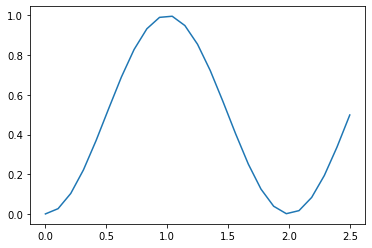

In [7]:
clean = res.expect([obs])[0]
plt.plot(sim._times, clean)
plt.show()

Now add SPAM errors to the simulation. You may use either `add_noise('SPAM')` or the more general `set_noise('SPAM')`.

In [8]:
sim.remove_all_noise()
sim.add_noise('SPAM')

In [9]:
sim._noise

['SPAM']

This is the spam parameters dictionary. `eta` is the probability of a badly prepared state, `epsilon` the false positive probability, `epsilon_prime` the false negative one.

In [10]:
sim.spam_dict

{'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}

In [11]:
sim.show_config()

{'eval_t': 'Full', 'runs': 1, 'samples_per_run': 10, 'initial_state': Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]}


You may change different settings of the simulation. `'runs'` indicates the number of times a noisy simulation is run to obtain the average of several simulation, `'samples_per_run'` is the number of delivered samples per run - this has no physical interpretation, this is used simply to cut down on calculation time.

In [12]:
sim.config('runs', 20)
sim.config('samples_per_run', 10)
sim.show_config()

{'eval_t': 'Full', 'runs': 20, 'samples_per_run': 10, 'initial_state': Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]}


We now obtain a `NoisyResults` object from our noisy simulation. This object represents the final result as a probability distribution over the sampled bitstrings, rather than a quantum state `QObj` in the `CleanResults` case.

In [13]:
res = sim.run()

The new `res` instance has similar methods to the usual `SimResults` object. For example, we can calculate expectation values:

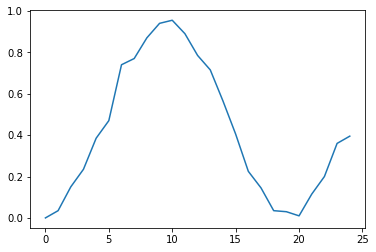

In [14]:
plt.plot(res.expect([obs])[0])

You can use the `plot` method to plot expectation values of a given observable. Here we compute the `sigma_z` local operator expectation values. You may choose to add error bars using the argument `error_bars = True`. 

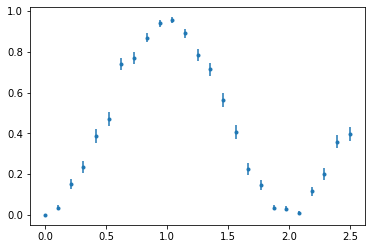

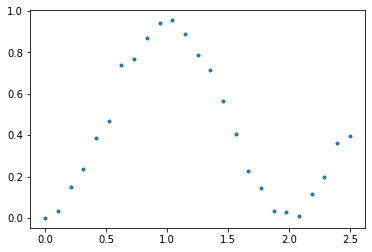

In [33]:
plt.figure(1)
res.plot(obs)
plt.figure(2)
res.plot(obs, error_bars=False)
plt.show()

In [16]:
# Store original time list:
t_list = sim.eval_times

Notice that by default the answer corresponds only to the final state of the evolution. To study the full-time dynamics with error, we indicate a specific time in the evolution with the parameter `t`.

Let us now create a function that evaluates noisy evolution for the entire time list of the simulation, which can also accept SPAM parameters :

In [17]:
def spam_evolution(**spam_param):
    sim.set_spam(**spam_param)
    res = sim.run()
    return res.expect([obs])[0]

In [18]:
sim.config('runs', 70)
noisy = spam_evolution(eta=0.4)

Compare both clean and noisy simulations for the default SPAM parameters (taken from [De Léséleuc, et al., 2018](https://arxiv.org/abs/1802.10424))

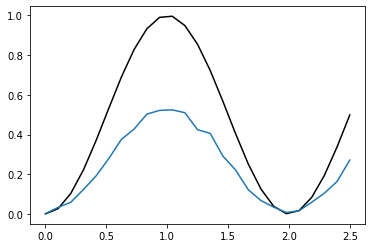

In [19]:
plt.plot(t_list, clean, 'k')
plt.plot(t_list, noisy)
plt.show()

We can see here that the population doesn't go well above $0.6 = 1 - \eta$, which is to be expected : badly prepared atoms don't reach state $\Ket{r}$. We can expect this limit of $0.6$ in the Rydberg population to be more and more respected as the number of runs and samples per run grows.

You may also modify the *SPAM* dictionary.

In [20]:
sim.set_spam(eta=0.005, epsilon=.99)
res_spam = sim.run()
res_spam.expect([obs])[0]

array([0.99      , 0.99      , 0.99142857, 0.99      , 0.97285714,
       0.96714286, 0.97      , 0.94142857, 0.95714286, 0.93428571,
       0.95142857, 0.95714286, 0.94285714, 0.96571429, 0.95285714,
       0.97857143, 0.98714286, 0.97428571, 0.99571429, 0.99142857,
       0.98571429, 0.99      , 0.97285714, 0.97857143, 0.97714286])

### Changing $\eta$

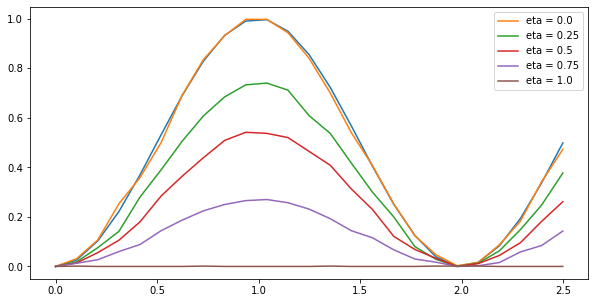

In [21]:
plt.figure(figsize=(10,5))
plt.plot(sim._times, clean)
for eta in np.linspace(0,1,5):
    plt.plot(t_list, spam_evolution(eta=eta, epsilon=0, epsilon_prime=0), label=f'eta = {eta}')
plt.legend()
plt.show()

As $\eta$ grows, more qubits are not well-prepared and we stop seeing occupations at all. You may increase the number of runs to smooth the curves.

### Changing $\epsilon$

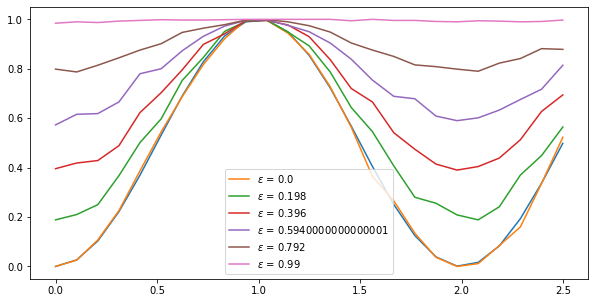

In [22]:
plt.figure(figsize=(10,5))
plt.plot(sim._times, clean)
for epsilon in np.linspace(0,.99,6):
    plt.plot(sim._times, spam_evolution(eta=0, epsilon=epsilon, epsilon_prime=0),
             label=rf'$\epsilon$ = {epsilon}')
plt.legend()
plt.show()

As more false negatives appear, it looks like the system is never captured, so always in a Rydberg state.

### Changing $\epsilon'$

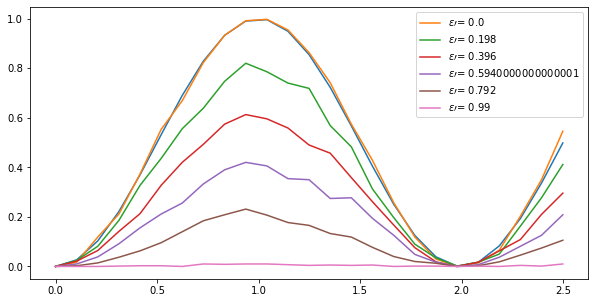

In [23]:
plt.figure(figsize=(10,5))
plt.plot(sim._times, clean)
for eps_pr in np.linspace(0,.99,6):
    plt.plot(sim._times, spam_evolution(eta=0, epsilon=0, epsilon_prime=eps_pr),
             label=rf'$\epsilon\prime$= {eps_pr}')
plt.legend()
plt.show()

As there are more false positives, all atoms seem to be recaptured, until no occupation is detected.

## Doppler Noise

We can add Doppler noise to our simulation with the `add_noise('doppler')` method. Let's increase the number of runs in order to get smoother curves. We remove the SPAM noise and set Doppler noise at the same time using the `set_noise` method.

In [24]:
sim.config('runs', 300)
sim.config('samples_per_run', 1)
sim.set_noise('doppler')
sim._noise

['doppler']

You may change the standard deviation of the doppler noise, which is $k \times \sqrt{k_B T / m}$, where $k$ is the effective wavevector of the lasers, using `set_doppler_sigma`.

In [25]:
sim.doppler_sigma = 4
sim.temperature = 50
#sim.init_doppler_sigma()
sim.doppler_sigma

0.600149981254686

Let us now simulate the entire sequence with Doppler noise, much like what we did in the SPAM case. We should see damped oscillations if the standard deviation is high enough :

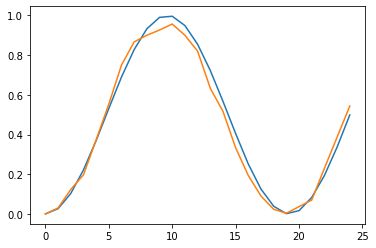

In [26]:
plt.plot(clean)
plt.plot(sim.run().expect([obs])[0])
plt.show()

## Multiple Atoms

We add the SPAM errors into the AFM state preparation sequence:

C:/Users/J64Th/OneDrive/文档/Stage 3A/Pasqal-io develop/Pulser\pulser\channels.py:106: UserWarning: A duration of 250 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  warnings.warn(f"A duration of {duration} ns is not a multiple of "


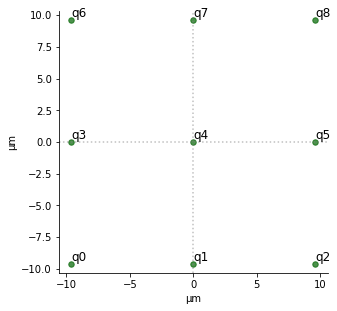

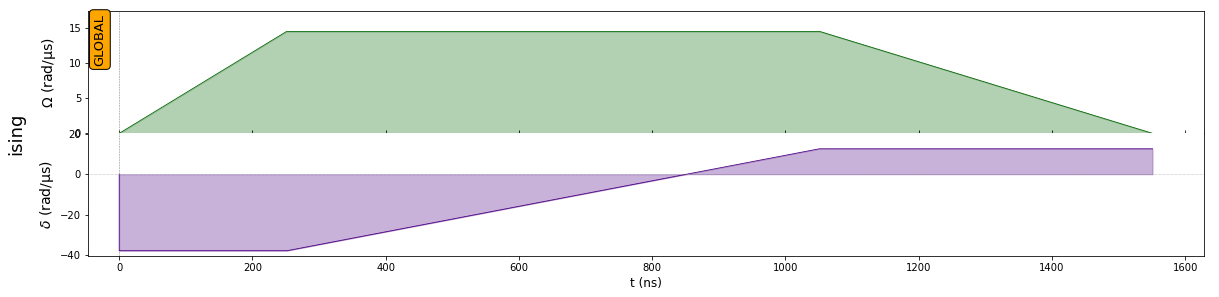

In [27]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2*np.pi 
U = Omega_max / 2.3
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 250
t_fall = 500
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 1000
R_interatomic = Chadoq2.rydberg_blockade_radius(U)

N_side = 3
reg = Register.rectangle(N_side, N_side, R_interatomic, prefix='q')

rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq = Sequence(reg, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

reg.draw()
seq.draw()

In [28]:
simul = Simulation(seq, sampling_rate=0.05)
clean_results = simul.run()
simul.set_noise('SPAM', 'doppler', 'amplitude')
print(simul._noise)
simul.config('runs', 50)
simul.config('samples_per_run', 10)
simul.init_spam()
spam_results = simul.run()

['SPAM', 'doppler', 'amplitude']


We now plot the simulation results by sampling the final states. Notice how `NoisyResults.sample_final_state()` has no `meas_basis` argument, since `NoisyResults` are already projected as bitstrings and not quantum states.

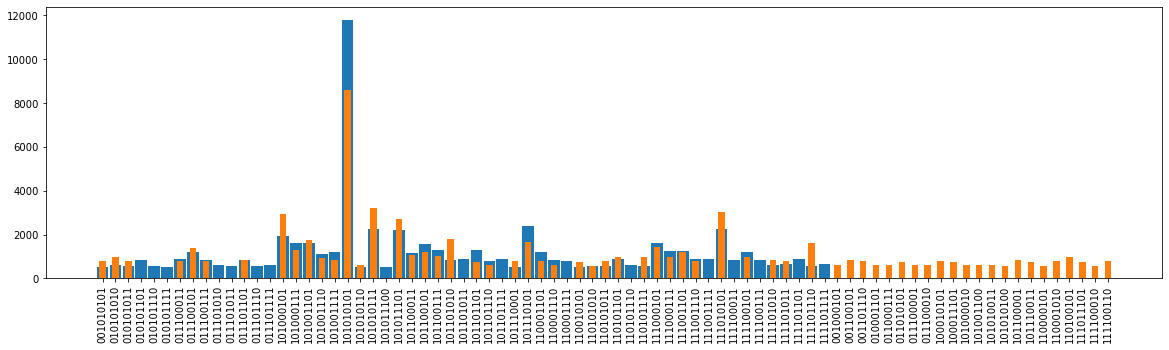

In [29]:
plt.figure(figsize=(20,5))

spam_count = spam_results.sample_final_state(N_samples=1e5)
clean_count = clean_results.sample_final_state(meas_basis='ground-rydberg', N_samples=1e5)

clean_most_freq = {k:v for k,v in clean_count.items() if v>500}
spam_most_freq = {k:v for k,v in spam_count.items() if v>500}

plt.bar(list(clean_most_freq.keys()), list(clean_most_freq.values()), width=0.9)
plt.bar(list(spam_most_freq.keys()), list(spam_most_freq.values()), width=0.5)

plt.xticks(rotation='vertical')
plt.show()

The bars represent the simulation results as populations of bitstrings. They're colored blue for the noiseless simulation, and orange for the noisy one. We clearly identify the antiferromagnetic state as the most populated one in both cases, but it is slightly less populated in the noisy case, while some other bitstrings, not present in the noiseless case, appear.